## Advanced ML HW1 

### 1. Data preprocessing

Скачайте данные в формате csv, выберите из таблицы данные по России, начиная с 3 марта 2020 г. (в этот момент впервые стало больше 2 заболевших). В качестве целевой переменной возьмём число случаев заболевания (столбцы total_cases и new_cases); для упрощения обработки можно заменить в столбце new_cases все нули на единицы. Для единообразия давайте зафиксируем тренировочный набор в виде первых 50 отсчётов (дней), начиная с 3 марта; остальные данные можно использовать в качестве тестового набора (и он даже будет увеличиваться по мере выполнения задания).

In [274]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [275]:
data = pd.read_csv('owid-covid-data.csv', parse_dates=['date'], index_col=['date'])
data = data[data['location']=='Russia']['2020-03-3':]
data = data[['total_cases', 'new_cases']]
data['new_cases'].replace({0: 1}, inplace=True)
data['total_cases'].replace({0: 1}, inplace=True)
data = data[:-1]
train_data = data[:50].copy()
test_data = data[50:].copy()

In [276]:
data.describe()

,total_cases,new_cases
count,1.100000e+03,1100.000000
mean,9.713831e+06,20330.680909
std,7.970303e+06,27717.691090
min,3.000000e+00,1.000000
25%,2.368510e+06,6382.750000
50%,6.984564e+06,11372.000000
75%,1.835269e+07,23989.500000
max,2.236374e+07,203949.000000


In [277]:
data.head(3)

,total_cases,new_cases
date,,
2020-03-03,3.0,1.0
2020-03-04,3.0,1.0
2020-03-05,3.0,1.0


In [278]:
train_data.shape, test_data.shape

((50, 2), (1050, 2))

### 2 Target Graphs

Постройте графики целевых переменных. Вы увидите, что число заболевших растёт очень быстро, на первый взгляд экспоненциально.

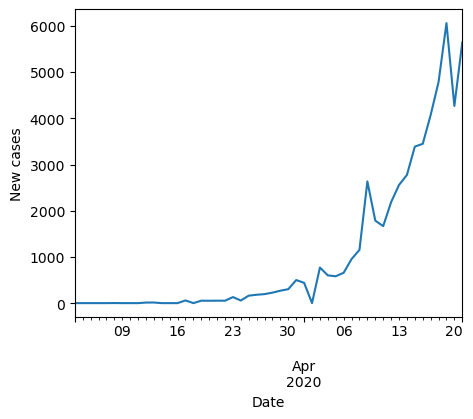

In [279]:
# Постройте графики целевых переменных
plt.figure(figsize=(5, 4))
train_data['new_cases'].plot(kind='line')
plt.xlabel('Date')
plt.ylabel('New cases')
plt.show()

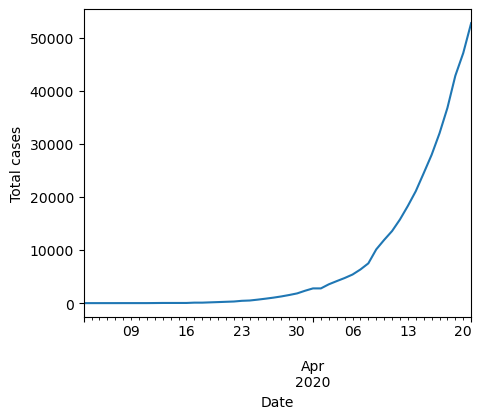

In [280]:
plt.figure(figsize=(5, 4))
train_data['total_cases'].plot(kind='line')
plt.xlabel('Date')
plt.ylabel('Total cases')
plt.show()

### 2a Linear Regression

Используя линейную регрессию, обучите модель с экспоненциальным ростом числа заболевших: 

y ~ exp(линейная функция от x), где x — номер текущего дня.

In [281]:
X = np.array([i + 1 for i in range(train_data.shape[0])]).reshape(-1, 1)
y_total = train_data['total_cases'].values.reshape(-1, 1)
y_new = train_data['new_cases'].values.reshape(-1, 1)

model_total = LinearRegression()
model_new = LinearRegression()
model_total.fit(X, np.log(y_total))
model_new.fit(X, np.log(y_new))

y_total_pred = model_total.predict(X)
y_new_pred = model_new.predict(X)

y = exp**(0.21 * x + 0.98)


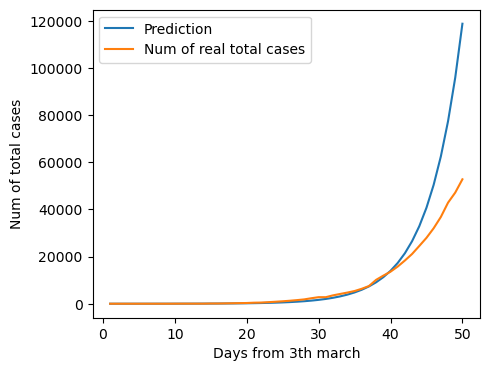

In [282]:
plt.figure(figsize=(5, 4))
plt.plot(X, np.exp(y_total_pred))
plt.plot(X, y_total)
plt.xlabel('Days from 3th march')
plt.ylabel('Num of total cases')
plt.legend(['Prediction', 'Num of real total cases'])
print(f'y = exp**({round(model_total.coef_[0][0], 2)} * x + {round(model_total.intercept_[0], 2)})');

y = exp**(0.2 * x + -0.61)


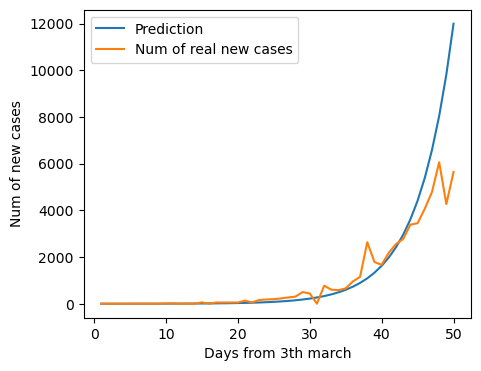

In [284]:
plt.figure(figsize=(5, 4))
plt.plot(X, np.exp(y_new_pred))
plt.plot(X, y_new)
plt.xlabel('Days from 3th march')
plt.ylabel('Num of new cases')
plt.legend(['Prediction', 'Num of real new cases'])
print(f'y = exp**({round(model_new.coef_[0][0], 2)} * x + {round(model_new.intercept_[0], 2)})');

### 2b Distribution

Найдите апостериорное распределение параметров этой модели для достаточно широкого априорного распределения. Требующееся для этого значение дисперсии шума в данных оцените, исходя из вашей же максимальной апостериорной модели (это фактически первый шаг эмпирического Байеса)

In [285]:
def bayesian_update(mu, sigma, x, y, noise):
    sigma_n = np.linalg.inv(np.linalg.inv(sigma)+(1 / (noise ** 2)) * np.dot(x.T, x))# sigma n - 1
    mu_n = np.matmul(sigma_n, np.dot(np.linalg.inv(sigma), mu.T) + (1 / (noise ** 2)) * np.matmul(x.T, y))
    return mu_n, sigma_n

def bayes_parameters(X, y, noise):
    cur_mu, cur_sigma = np.array([0, 0]), 2 * np.array([[1, 0], [0, 1]])
    mu_n = cur_mu
    sigma_n = cur_sigma
    for x, y in zip(X, y):
        x = np.array([[1, x]])
        mu_n, sigma_n = bayesian_update(mu_n, sigma_n, x, y, noise)
    return mu_n, sigma_n

Mu: [0.97841128 0.21413309]
sigma: [[ 1.85338142e-03 -5.50509188e-05]
 [-5.50509188e-05  2.15934530e-06]]
y = e**(0.214133091455452x + 0.97841128225798)


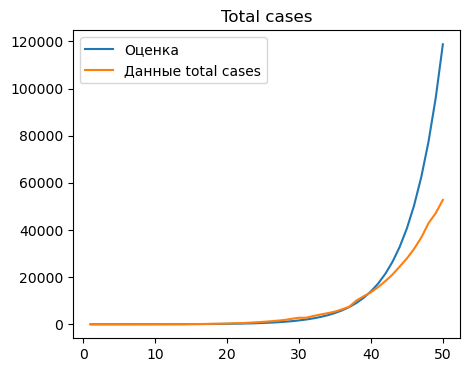

In [286]:
mu_total, sigma_total = bayes_parameters(np.arange(train_data.shape[0]) + 1, np.log(y_total), noise=0.15)
func = lambda x: np.exp(mu_total[0] + mu_total[1] * x)
print('Mu:', mu_total)
print('sigma:', sigma_total)
print(f'y = e**({mu_total[1]}x + {mu_total[0]})')
plt.figure(figsize=(5, 4))
plt.plot(X, [func(i) for i in X], label='Оценка')
plt.plot(X, y_total, label='Данные total cases')
plt.title('Total cases')
plt.legend()
plt.show()

Mu: [-0.604928    0.19992828]
sigma: [[ 3.29252509e-03 -9.77977293e-05]
 [-9.77977293e-05  3.83673915e-06]]
y = e**(0.19992827533702084x + -0.6049279991327268)


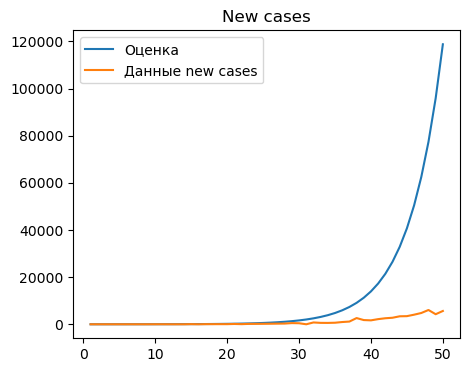

In [287]:
mu_new, sigma_new = bayes_parameters(np.arange(train_data.shape[0]) + 1, np.log(y_new), noise=0.2)
print('Mu:', mu_new)
print('sigma:', sigma_new)
print(f'y = e**({mu_new[1]}x + {mu_new[0]})')
plt.figure(figsize=(5, 4))
plt.plot(X, [func(i) for i in X], label='Оценка')
plt.plot(X, y_new, label='Данные new cases')
plt.title('New cases')
plt.legend()
plt.show()

### 2c Сэмплирование из апостериорного распределения

Посэмплируйте много разных экспонент, постройте графики.

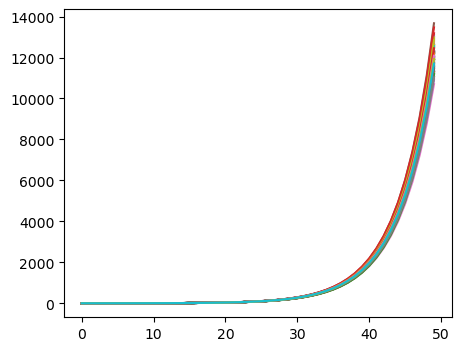

In [288]:
# New Cases
n_samples = 100
x_range = np.arange(train_data.shape[0]) + 1
sample = np.random.multivariate_normal(mu_new, sigma_new, n_samples)
plt.figure(figsize=(5, 4))
for w in sample:
    y = [[np.exp(w[0] + w[1] * x)] for x in x_range]
    plt.plot(y)

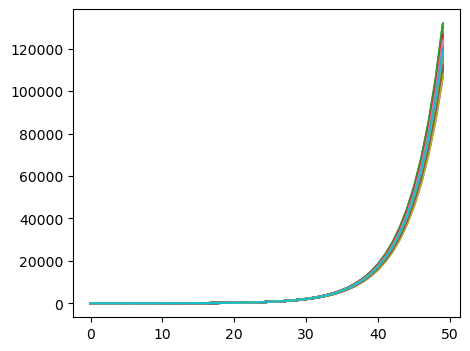

In [289]:
# Total Cases
x_range = np.arange(train_data.shape[0]) + 1
sample = np.random.multivariate_normal(mu_total, sigma_total, n_samples)
plt.figure(figsize=(5, 4))
for w in sample:
    y = [[np.exp(w[0] + w[1] * x)] for x in x_range]
    plt.plot(y)

Сколько, исходя из этих сэмплов, предсказывается случаев коронавируса в России к 1 мая? к 1 июня? к 1 сентября? Постройте предсказательные распределения (можно эмпирически, исходя из данных сэмплирования).

In [290]:
# Предсказываем случаи коронавируса в России к 1 мая? к 1 июня? к 1 сентября?
may = '2020-05-01'
juni = '2020-06-01'
september = '2020-09-01'

Mean total cases: 1011031.1


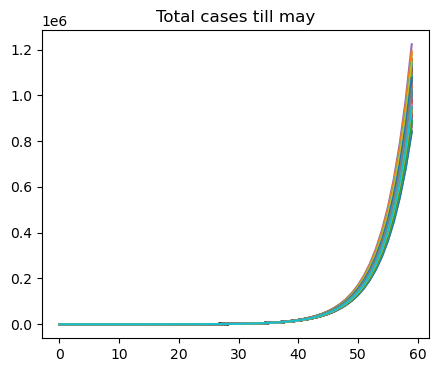

In [291]:
# Total Cases till 01 may
x_range = np.arange(data[:may].shape[0]) + 1
sample_may = np.random.multivariate_normal(mu_total, sigma_total, 1000)
plt.figure(figsize=(5, 4))
cases = []
for w in sample_may:
    y = [[np.exp(w[0] + w[1] * x)] for x in x_range]
    cases.append(y[-1])
    plt.plot(y)
plt.title('Total cases till may')
print('Mean total cases:', round(np.mean(cases), 1));

Mean total cases: 773254432.6


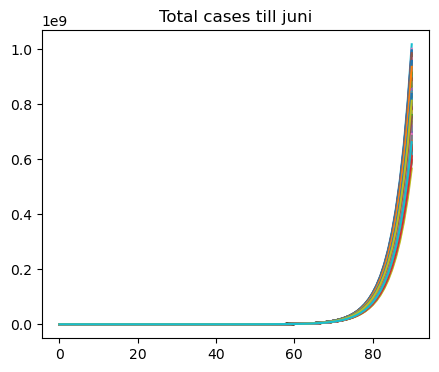

In [292]:
# Total Cases till 01 juni
x_range = np.arange(data[:juni].shape[0]) + 1
sample_juni = np.random.multivariate_normal(mu_total, sigma_total, 1000)
plt.figure(figsize=(5, 4))
cases = []
for w in sample_juni:
    y = [[np.exp(w[0] + w[1] * x)] for x in x_range]
    cases.append(y[-1])
    plt.plot(y)
plt.title('Total cases till juni')
print('Mean total cases:', round(np.mean(cases), 1));

Mean total cases: 287849766092475904


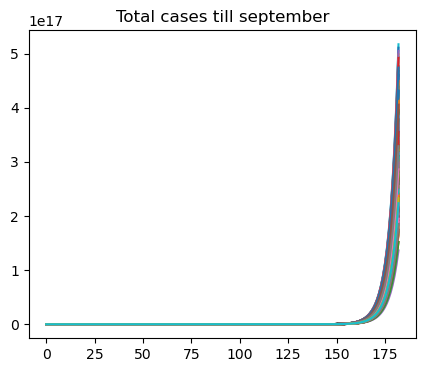

In [293]:
# Total Cases till 01 september
x_range = np.arange(data[:september].shape[0]) + 1
sample_september = np.random.multivariate_normal(mu_total, sigma_total, 1000)
plt.figure(figsize=(5, 4))
cases = []
for w in sample_september:
    y = [[np.exp(w[0] + w[1] * x)] for x in x_range]
    cases.append(y[-1])
    plt.plot(y)
plt.title('Total cases till september')
print('Mean total cases:', round(np.mean(cases)));

### 3. Предсказания экспоненциальной модели наверняка получились грустными. 
Но это, конечно, чересчур пессимистично — экспоненциальный рост в природе никак не может продолжаться вечно. Кривая общего числа заболевших во время эпидемии в реальности имеет сигмоидальный вид: после начальной фазы экспоненциального роста неизбежно происходит насыщение. В качестве конкретной формы такой сигмоиды давайте возьмём форму функции распределения для гауссиана

Естественно, в нашем случае сигмоида стремится не к единице, т.е. константа перед интегралом может быть произвольной (и её можно внести в экспоненту), а в экспоненте под интегралом может быть произвольная квадратичная функция от t.

### 3.а. Предложите способ обучать параметры такой сигмоидальной функции при помощи линейной регрессии.

В нашей задаче функция F будет давать нам распределение количества случаев заболевания ко дню х (интеграл от экспоненты по временному отрезку к моменту х). Тогда число заболевших y в день  можно представить в виде производной этой функции, а степень экспоненты расписать как квадратичную функцию х: 

w0 + w1 * x + w2 * x^2 

Тогда:
ln(y) = w0 + w1 * x + w2 * x^2

### 3.b Обучите эти параметры на датасете случаев коронавируса в России
Найдите апостериорное распределение параметров этой модели для достаточно широкого априорного распределения. Требующееся для этого значение дисперсии шума в данных оцените, исходя из вашей же максимальной апостериорной модели. 

In [294]:
model_sigma_total = LinearRegression()
model_sigma_new = LinearRegression()

y_total = train_data['total_cases'].values.reshape(-1, 1)
y_new = train_data['new_cases'].values.reshape(-1, 1)

X_square = np.array([(i + 1, (i + 1) ** 2) for i in range(train_data.shape[0])])
model_sigma_total.fit(X_square, np.log(y_total))
model_sigma_new.fit(X_square, np.log(y_new))

y_sigma_total_pred = model_sigma_total.predict(X_square)
y_sigma_new_pred = model_sigma_new.predict(X_square)

y = e**(0.32x + -0.0x^2 + 0.07)


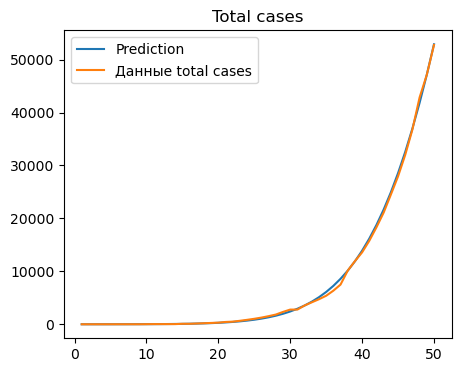

In [295]:
print(f'y = e**({round(model_sigma_total.coef_[0][0], 2)}x + {round(model_sigma_total.coef_[0][1], 2)}x^2 + {round(model_sigma_total.intercept_[0], 2)})')

plt.figure(figsize=(5, 4))
plt.plot(X, np.exp(y_sigma_total_pred), label='Prediction')
plt.plot(X, y_total.ravel(), label='Данные total cases')
plt.title('Total cases')
plt.legend()
plt.show();

y = e**(0.26x + -0.0x^2 + -1.13)


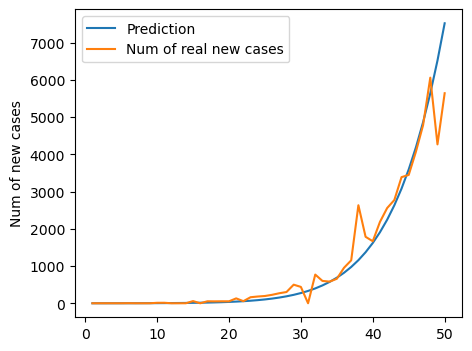

In [296]:
print(f'y = e**({round(model_sigma_new.coef_[0][0], 2)}x + {round(model_sigma_new.coef_[0][1], 2)}x^2 + {round(model_sigma_new.intercept_[0], 2)})')

plt.figure(figsize=(5, 4))
plt.plot(X, np.exp(y_sigma_new_pred))
plt.plot(X, y_new)
plt.ylabel('Num of new cases')
plt.legend(['Prediction', 'Num of real new cases']);

In [297]:
# апостериорное распределение
def bayesian_update(mu, sigma, x, y, noise):
    sigma_n = np.linalg.inv(np.linalg.inv(sigma)+(1 / (noise ** 2)) * np.dot(x.T, x))# sigma n - 1
    mu_n = np.matmul(sigma_n, np.dot(np.linalg.inv(sigma), mu.T) + (1 / (noise ** 2)) * np.matmul(x.T, y))
    return mu_n, sigma_n

def bayes_parameters(X, y, noise):
    cur_mu, cur_sigma = np.array([0, 0, 0]), 2 * np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
    mu_n = cur_mu
    sigma_n = cur_sigma
    for x, y in zip(X, y):
        x = np.array([[1] + x.tolist()])
        mu_n, sigma_n = bayesian_update(mu_n, sigma_n, x, y, noise)
    return mu_n, sigma_n

In [298]:
mu_new, sigma_new = bayes_parameters(X_square, np.log(y_new), noise=0.15)
print(mu_new)
print(sigma_new)

[-1.12950319  0.26046028 -0.00118693]
[[ 4.38240749e-03 -3.47063225e-04  5.72710389e-06]
 [-3.47063225e-04  3.58763511e-05 -6.61276224e-07]
 [ 5.72710389e-06 -6.61276224e-07  1.29693084e-08]]


### 3c. Посэмплируйте много разных сигмоид из апостериорного распределения, постройте графики. 
Сколько, исходя из этих сэмплов, будет всего случаев коронавируса в России? Постройте эмпирическое предсказательное распределение, нарисуйте графики. Каков ваш прогноз числа случаев коронавируса в пессимистичном сценарии (90-й процентиль в выборке числа случаев)? В оптимистичном сценарии (10-й процентиль)?

Среднее число заболевших в 50 день пандемии 7529.82


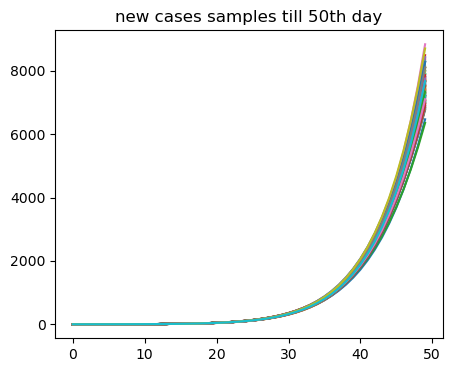

In [299]:
# New Cases
n_samples = 100
x_range = np.arange(train_data.shape[0]) + 1
sample = np.random.multivariate_normal(mu_new, sigma_new, n_samples)
plt.figure(figsize=(5, 4))
cases = []
all_preds = []
for w in sample:
    y = [[np.exp(w[0] + w[1] * x + w[2] * (x ** 2))] for x in x_range]
    cum_preds = list(np.exp(w[0] + w[1] * x + w[2] * (x ** 2)) for x in x_range)
    cum_preds = np.cumsum(cum_preds)
    all_preds.append(list(np.array(cum_preds).reshape(1, -1)[0]))
    cases.append(y[-1])    
    plt.plot(y)
print('Среднее число заболевших в 50 день пандемии', round(np.mean(cases), 2))
plt.title('new cases samples till 50th day');

Количество заболевших: 52143.43


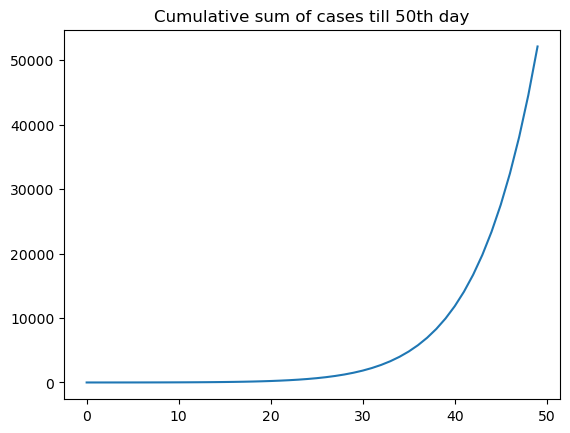

In [300]:
plt.title('Cumulative sum of cases till 50th day')
print('Количество заболевших:', round(np.mean(np.array(all_preds).T, axis=1)[-1], 2));
plt.plot(np.mean(np.array(all_preds).T, axis=1));

Mean new cases in may: 27740.2


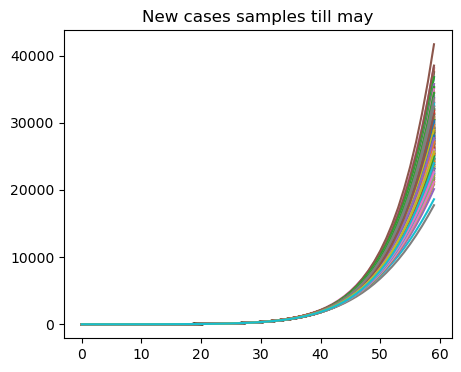

In [301]:
# New Cases till 01 may
x_range = np.arange(data[:may].shape[0]) + 1
sample_may = np.random.multivariate_normal(mu_new, sigma_new, 500)
plt.figure(figsize=(5, 4))
cases = []
all_preds = []
for w in sample_may:
    y = [[np.exp(w[0] + w[1] * x + w[2] * (x ** 2))] for x in x_range]
    cum_preds = list(np.exp(w[0] + w[1] * x + w[2] * (x ** 2)) for x in x_range)
    cum_preds = np.cumsum(cum_preds)
    all_preds.append(list(np.array(cum_preds).reshape(1, -1)[0]))
    cases.append(y[-1])
    plt.plot(y)
plt.title('New cases samples till may')
print('Mean new cases in may:', round(np.mean(cases), 1));

Количество заболевших к 01.05: 220422.75


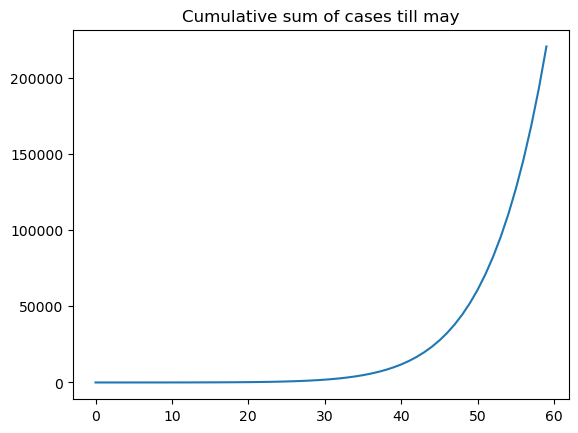

In [302]:
plt.title('Cumulative sum of cases till may')
plt.plot(np.mean(np.array(all_preds).T, axis=1))
print('Количество заболевших к 01.05:', round(np.mean(np.array(all_preds).T, axis=1)[-1], 2));

Mean new cases in june: 388651.9


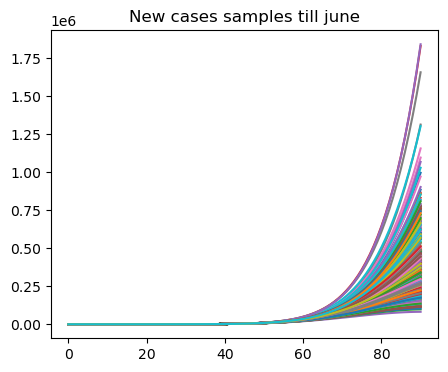

In [303]:
# Total Cases till 01 juni
x_range = np.arange(data[:juni].shape[0]) + 1
sample_juni = np.random.multivariate_normal(mu_new, sigma_new, 500)
plt.figure(figsize=(5, 4))
cases = []
all_preds = []
for w in sample_juni:
    y = [[np.exp(w[0] + w[1] * x + w[2] * (x ** 2))] for x in x_range]
    cum_preds = list(np.exp(w[0] + w[1] * x + w[2] * (x ** 2)) for x in x_range)
    cum_preds = np.cumsum(cum_preds)
    all_preds.append(list(np.array(cum_preds).reshape(1, -1)[0]))
    cases.append(y[-1])
    plt.plot(y)
plt.title('New cases samples till june')
print('Mean new cases in june:', round(np.mean(cases), 1));

Количество заболевших к 01.06: 5362545.5


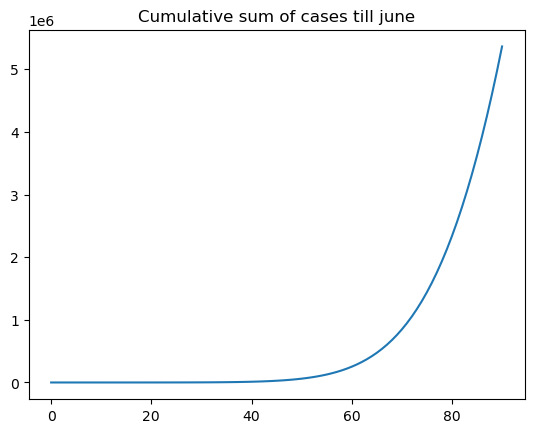

In [304]:
plt.title('Cumulative sum of cases till june')
plt.plot(np.mean(np.array(all_preds).T, axis=1))
print('Количество заболевших к 01.06:', round(np.mean(np.array(all_preds).T, axis=1)[-1], 2));

Mean new cases in september: 21031.3


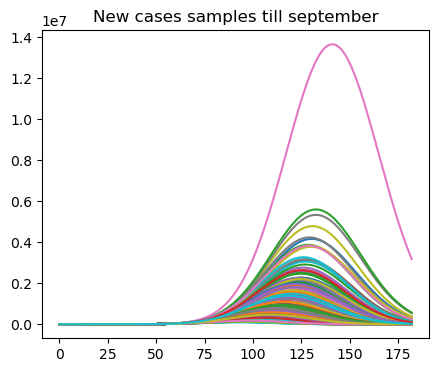

In [306]:
# Total Cases till 01 september
x_range = np.arange(data[:september].shape[0]) + 1
sample_september = np.random.multivariate_normal(mu_new, sigma_new, 500)
plt.figure(figsize=(5, 4))
cases = []
all_preds = []
for w in sample_september:
    y = [[np.exp(w[0] + w[1] * x + w[2] * (x ** 2))] for x in x_range]
    cum_preds = list(np.exp(w[0] + w[1] * x + w[2] * (x ** 2)) for x in x_range)
    cum_preds = np.cumsum(cum_preds)
    all_preds.append(list(np.array(cum_preds).reshape(1, -1)[0]))
    cases.append(y[-1])
    plt.plot(y)
plt.title('New cases samples till september')
print('Mean new cases in september:', round(np.mean(cases), 1));

Количество заболевших к 01.09: 41730006.72


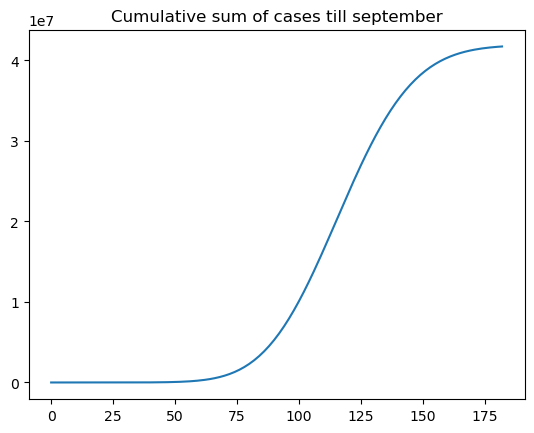

In [307]:
plt.title('Cumulative sum of cases till september')
plt.plot(np.mean(np.array(all_preds).T, axis=1))
print('Количество заболевших к 01.09:', round(np.mean(np.array(all_preds).T, axis=1)[-1], 2));

### Оценим количество заболевших к текущему моменту

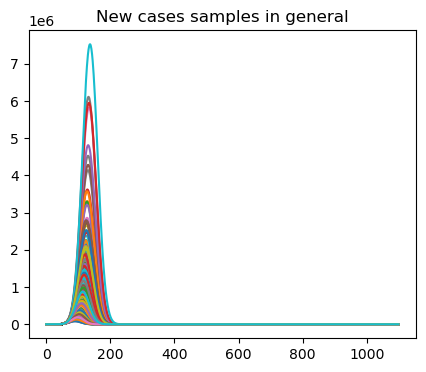

In [315]:
# Total Cases
x_range = np.arange(data[:].shape[0]) + 1
sample = np.random.multivariate_normal(mu_new, sigma_new, 500)
plt.figure(figsize=(5, 4))
cases = []
all_preds = []
for w in sample:
    y = [[np.exp(w[0] + w[1] * x + w[2] * (x ** 2))] for x in x_range]
    cum_preds = list(np.exp(w[0] + w[1] * x + w[2] * (x ** 2)) for x in x_range)
    cum_preds = np.cumsum(cum_preds)
    all_preds.append(list(np.array(cum_preds).reshape(1, -1)[0]))
    cases.append(y[-1])
    plt.plot(y)
plt.title('New cases samples in general');

Количество заболевших всего: 42453538.66


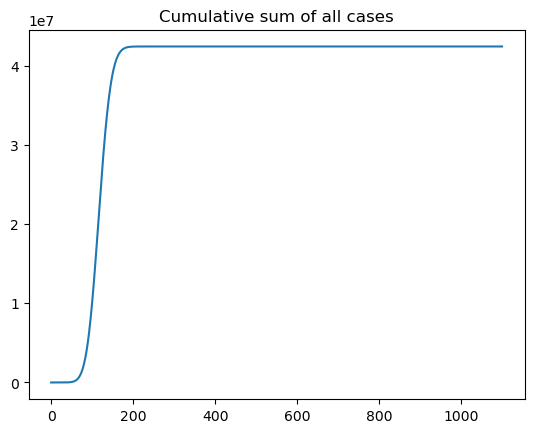

In [316]:
result = np.mean(np.array(all_preds).T, axis=1)
plt.title('Cumulative sum of all cases')
plt.plot(result)
print('Количество заболевших всего:', round(result[-1], 2));

In [319]:
print('Прогноз числа заболевших в оптимистичном сценарии', round(pd.DataFrame(result).quantile(0.1), 3)[0])

Прогноз числа заболевших в оптимистичном сценарии 16568770.791


In [320]:
print('Прогноз числа заболевших в пессиместичном сценарии', round(pd.DataFrame(result).quantile(0.9), 3)[0])

Прогноз числа заболевших в пессиместичном сценарии 42453538.657
